# CICE6 Standalone Analysis Notebook

In [8]:
import xarray as xr
import numpy as np
import cftime
import datetime
import sys, os, warnings
import dask
from dask.distributed import Client
from datetime import timedelta
import glob
import os
from datatree import DataTree, map_over_subtree
import socket
import pandas as pd
from tqdm.notebook import tqdm
import sys
sys.path.append("/home/566/nd0349/access-om3-analysis/functions")
from plot_settings import *

warnings.filterwarnings('ignore')

In [9]:
def get_path(experiments):
    hostname = socket.gethostname()
    if "gadi" in hostname:
        machine = "gadi"
        #path = "/g/data/ps29/nd0349/runs/cice6/"
        path = "/scratch/ps29/nd0349/CICE_RUNS/"
        fig_path = "/home/566/nd0349/access-om3-analysis/figures/"
    elif "setonix" in hostname:
        machine = "setonix"
    else:
        machine = "noahday"
        path = "/Users/noahday/GitHub/cice-dev/cice-dirs/runs/"
        fig_path = "/Users/noahday/GitHub/access-om3-analysis/figures/"

    print(f"Running on {machine}")
        
    return path, fig_path


experiment_sets = {
    "test": ["sandbox"], #["baseline-1deg", "nofsd-1deg", "wave-profile-1deg"], # "sandbox", "test"
    "gx3": ["baseline-gx3", "wave-constant-gx3", "wave-profile-gx3", "wave-random-gx3"],
    "baseline": ["baseline-1deg", "baseline-025deg"],
    "wave-1deg": ["nofsd-1deg"], # "wave-profile-1deg", "wave-random-1deg" , "nofsd-1deg"
}
experiments = experiment_sets["wave-1deg"]
# machine = "gadi" # "noahday" or "gadi"

#["baseline-1deg", "wave-constant-1deg"] 
n_expts = len(experiments)
expt_path, fig_path = get_path(experiments)
histfreq = ["m", "m", "m", "m", "m", "m", "d", "d"] # "h" or "d" or "m"

basic_ice_vars = ["aice", "hi", "iage", "icespd"]
atm_forcing_vars = ["Tair", "uatm", "vatm", "Qref", "fswdn", "flwdn", "snow"]
# 10m Air temperature, wind components, 2m specific humiditiy, incoming long wave radiation, incoming long wave radiation
# Tair, uatm, vatm, Qa, fsw, flw, fsnow from ice_forcing.F90/JRA55_data

ocn_forcing_vars = ["sst", "sss", "uocn", "vocn"]
wave_forcing_vars = ["wave_sig_ht"] # peak period? MWD?

VARS = basic_ice_vars + atm_forcing_vars + ocn_forcing_vars + wave_forcing_vars
keep_vars = ["TLAT", "TLON", "time", "tarea"] + VARS

# Create an empty dictionary to store datasets
datasets = {}

for i, expt in enumerate(experiments):
    print(expt)
    path = os.path.join(expt_path, expt, "history/")
    if histfreq[i] == "h":
        file_pattern = os.path.join(path, "iceh_01h.????-??-??-?????.nc")
        time_delta = timedelta(minutes=30)
    elif histfreq[i] == "d":
        file_pattern = os.path.join(path, "iceh.????-??-??.nc")
        time_delta = timedelta(hours=12)
    elif histfreq[i] == "m":
        file_pattern = os.path.join(path, "iceh.????-??.nc")  # Adjust this if needed
        time_delta = timedelta(days=16)
    files = sorted(glob.glob(file_pattern))
    
    if not files:
        print(f"No files found for {expt}, skipping...")
        continue

    sample_ds = xr.open_dataset(files[0])
    drop_vars = [var for var in sample_ds.variables if var not in keep_vars]

    if expt == "baseline-1deg":
        files = files[:12]
        
    ds = xr.open_mfdataset(
        files, 
        # chunks="auto",
        decode_times=True, # 
        decode_timedelta=True,
        drop_variables=drop_vars,
        use_cftime=True 
    )

    ds["time"] = ds["time"].to_pandas() - time_delta

    datasets[expt] = ds  # Store the dataset in the dictionary

dt = DataTree.from_dict({expt: DataTree(data=ds) for expt, ds in datasets.items()})
dt

Running on gadi
nofsd-1deg


DataTree('None', parent=None)
└── DataTree('nofsd-1deg')
        Dimensions:  (time: 612, nj: 300, ni: 360)
        Coordinates:
          * time     (time) object 5kB 1958-01-16 00:00:00 ... 2008-12-16 00:00:00
            TLON     (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
            TLAT     (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
        Dimensions without coordinates: nj, ni
        Data variables: (12/14)
            tarea    (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            hi       (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            aice     (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            icespd   (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            uatm     (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            vatm     (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            ...       ...
            sst      (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            sss      (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            uocn     (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            vocn     (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            Tair     (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
            iage     (time, nj, ni) float32 264MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
        Attributes:
            title:               sea ice model output for CICE
            contents:            Diagnostic and Prognostic Variables
            source:              Los Alamos Sea Ice Model, CICE_6.6.0
            comment:             All years have exactly 365 days
            comment2:            File written on model date 19580201
            comment3:            seconds elapsed into model date:      0
            time_period_freq:    month_1
            time_axis_position:  end
            conventions:         CF-1.0
            history:             This dataset was created on 2025-06-05 at 14:18:59.4
            io_flavor:           io_netcdf

In [10]:
# # sample_ds = xr.open_dataset(files[-1], decode_times=False)
# # sample_ds.time
# # files
# # dt['/wave-random-1deg']['aice'].isel(time=-1).plot()

# days = dt['/wave-random-1deg']['time']
# start_date = np.datetime64("1958-01-01")
# dates = start_date + days.astype("timedelta64[D]")
# # If you want the dates in "days since 1958-01-01" format again:
# days_since = (dates - start_date).astype('timedelta64[D]').astype(int)

# dt['/wave-random-1deg']['time'] = dates

In [11]:
# fig, ax = plt.subplots(figsize=(10, 5),
                       # subplot_kw={'projection': ccrs.SouthPolarStereo()})

# dt['/wave-random-1deg']['aice'].isel(time=-1).plot(ax=ax, 
                                                   # transform=ccrs.PlateCarree())


In [12]:
%matplotlib inline
def basic_axis(dims, hemisphere="south"):
    if hemisphere=="south":
        projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
        extent = [-180, 180, -90, -45]
    else:
        projection = ccrs.NorthPolarStereo(true_scale_latitude=90)
        extent = [-180, 180, 60, 90]
        
    # Determine number of rows and columns for subplots
    ncols = dims[1]#int(np.ceil(np.sqrt(number_panels)))
    nrows = dims[0]#int(np.ceil(number_panels / ncols))
    number_panels = ncols*nrows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        subplot_kw={'projection': projection},
        figsize=(4 * ncols, 4 * nrows),  # Adjust figure size
        gridspec_kw={'wspace': 0.15, 'hspace': 0.15}  # Adjust spacing
    )
    
    if number_panels == 1:
        axes = np.array([[axes]])  # Ensure axes is always a 2D array
    elif nrows == 1 or ncols == 1:
        axes = axes.reshape((nrows, ncols))
    
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray', linewidth=0.5)
    
    for ax in axes.flat[:number_panels]:  # Only iterate over required axes
        ax.set_global()
        ax.coastlines(resolution='50m')
        ax.add_feature(land_50m)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Hide unused subplots if necessary
    for ax in axes.flat[number_panels:]:
        ax.set_visible(False)
    axes = axes.flatten()
    return fig, axes

In [13]:
# dt[iGroup].isel(time=time_idx-1).copy()['time'].item()
# str(dt[iGroup].isel(time=time_idx-1).copy()['time'].item())
# pd.Timestamp(str(dt[iGroup].isel(time=time_idx-1).copy()['time'].item()))
# pd.Timestamp(dt[iGroup].isel(time=time_idx-1).copy()['time'].item())

Error plotting variable 'aice': name 're' is not defined. Skipping.
Error plotting variable 'iage': name 're' is not defined. Skipping.
Error plotting variable 'hi': name 're' is not defined. Skipping.
Error plotting variable 'wave_sig_ht': name 're' is not defined. Skipping.


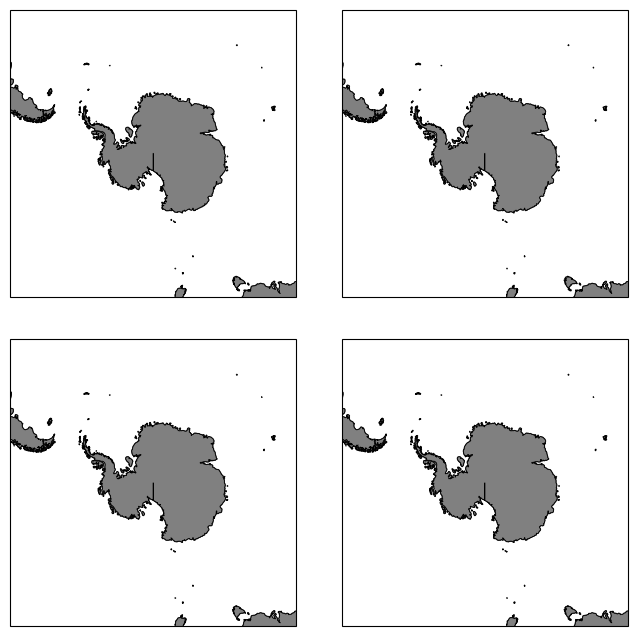

In [14]:
time_idx = -1 # 1 = Jan

for i, iGroup in enumerate(dt.groups[1:]):
    if histfreq[i] == "h":
        time_abbr = pd.Timestamp(str(dt[iGroup].isel(time=time_idx-1).copy()['time'].item()))
    elif histfreq[i] == "d":
        time_abbr = pd.Timestamp(dt[iGroup].isel(time=time_idx-1).copy()['time'].item())
    elif histfreq[i] == "m":
        time_abbr = calendar.month_abbr[time_idx]

    
    fig, axes = basic_axis([2,2])
    ds_plot = dt[iGroup].isel(time=time_idx-1).copy()

    vars_to_plot = ["aice", "iage", "hi", "wave_sig_ht"]

    for idx, var in enumerate(vars_to_plot):
        try:
            settings = get_plot_settings(var)
            data = ds_plot[var]
            
            # Apply masking for specific variables if needed
            if var in ["hi", "iage", "wave_sig_ht"]:
                data = data.where(ds_plot["aice"] > 0.15)
            
            data.plot(
                ax=axes[idx], x="TLON", y="TLAT",
                cmap=settings.get("cmap"),
                vmin=settings.get("vmin"),
                vmax=settings.get("vmax"),
                transform=ccrs.PlateCarree()
            )
    
        except KeyError:
            print(f"Variable '{var}' not found in dataset. Skipping.")
        except Exception as e:
            print(f"Error plotting variable '{var}': {e}. Skipping.")
    
    plt.savefig(fig_path + f"/basic_vars_SH_{iGroup[1:]}_{time_abbr}.png", dpi=300, bbox_inches="tight") 

Error plotting variable 'aice': name 're' is not defined. Skipping.
Error plotting variable 'iage': name 're' is not defined. Skipping.
Error plotting variable 'hi': name 're' is not defined. Skipping.
Error plotting variable 'wave_sig_ht': name 're' is not defined. Skipping.


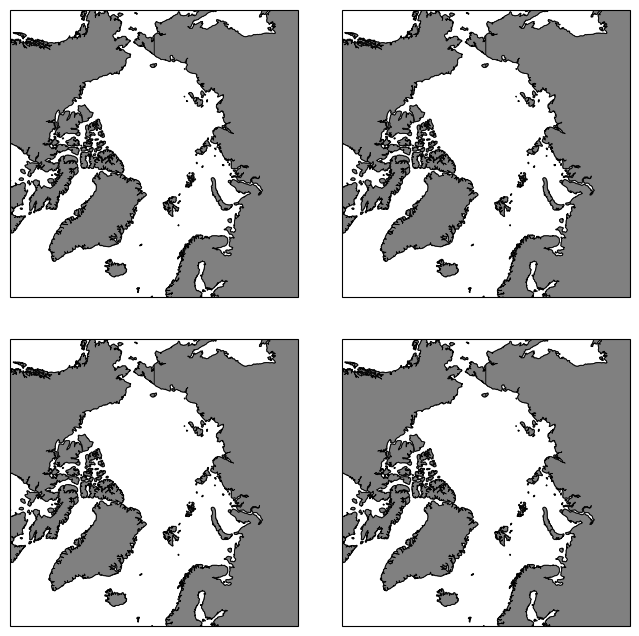

In [15]:
time_idx = -1 # 1 = Jan

for i, iGroup in enumerate(dt.groups[1:]):
    if histfreq[i] == "h":
        time_abbr = pd.Timestamp(str(dt[iGroup].isel(time=time_idx-1).copy()['time'].item()))
    elif histfreq[i] == "d":
        time_abbr = pd.Timestamp(dt[iGroup].isel(time=time_idx-1).copy()['time'].item())
    elif histfreq[i] == "m":
        time_abbr = calendar.month_abbr[time_idx]

    
    fig, axes = basic_axis([2,2], "north")
    ds_plot = dt[iGroup].isel(time=time_idx-1).copy()

    vars_to_plot = ["aice", "iage", "hi", "wave_sig_ht"]

    for idx, var in enumerate(vars_to_plot):
        try:
            settings = get_plot_settings(var)
            data = ds_plot[var]
            
            # Apply masking for specific variables if needed
            if var in ["hi", "iage", "wave_sig_ht"]:
                data = data.where(ds_plot["aice"] > 0.15)
            
            data.plot(
                ax=axes[idx], x="TLON", y="TLAT",
                cmap=settings.get("cmap"),
                vmin=settings.get("vmin"),
                vmax=settings.get("vmax"),
                transform=ccrs.PlateCarree()
            )
    
        except KeyError:
            print(f"Variable '{var}' not found in dataset. Skipping.")
        except Exception as e:
            print(f"Error plotting variable '{var}': {e}. Skipping.")
    
    plt.savefig(fig_path + f"/basic_vars_NH_{iGroup[1:]}_{time_abbr}.png", dpi=300, bbox_inches="tight") 

Variable 'Qref' not found in dataset. Skipping.
Variable 'snow' not found in dataset. Skipping.


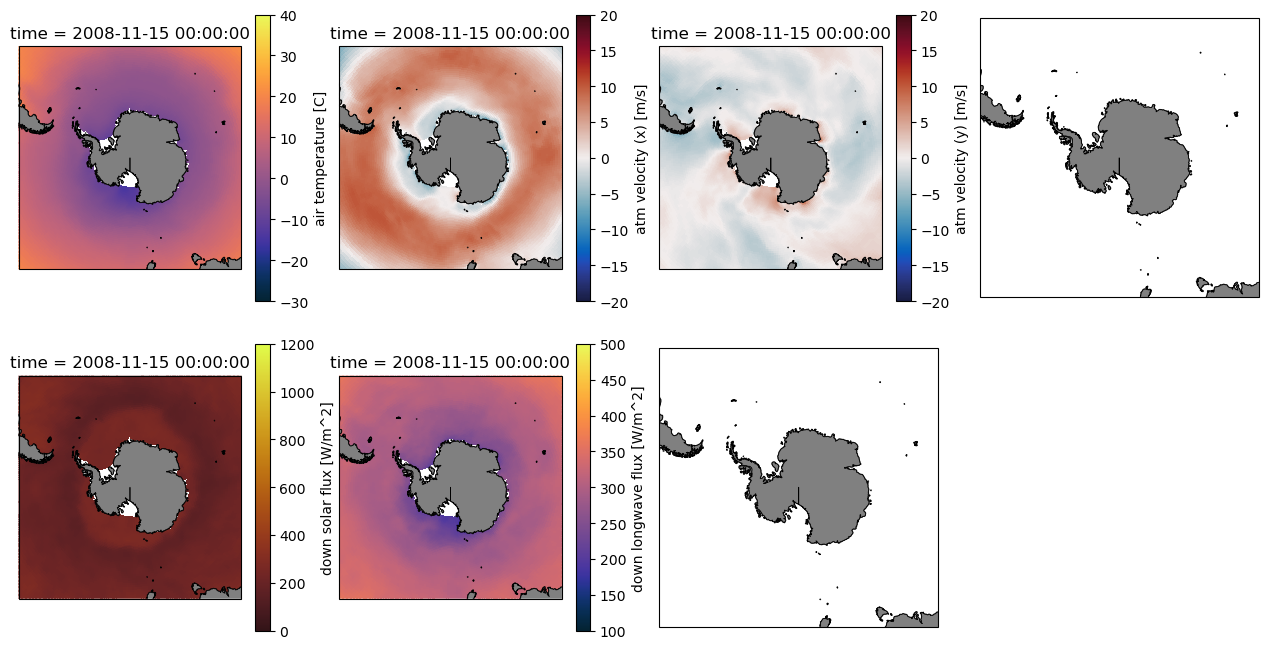

In [84]:
time_idx = -1 # 2 = Feb

for i, iGroup in enumerate(dt.groups[1:]):
    if histfreq[i] == "h":
        time_abbr = pd.Timestamp(str(dt[iGroup].isel(time=time_idx-1).copy()['time'].item()))
    elif histfreq[i] == "d":
        time_abbr = pd.Timestamp(dt[iGroup].isel(time=time_idx-1).copy()['time'].item())
    elif histfreq[i] == "m":
        time_abbr = calendar.month_abbr[time_idx]
    fig, axes = basic_axis([2, (len(atm_forcing_vars) + 1) // 2])
    
    ds_plot = dt[iGroup].isel(time=time_idx-1).copy()
    for i, var in enumerate(atm_forcing_vars):
        try:
            settings = get_plot_settings(var)
            settings
            ds_plot[var].plot(ax=axes.flat[i], x="TLON", y="TLAT", 
                              cmap=settings.get("cmap"),
                              vmin=settings.get("vmin"),
                              vmax=settings.get("vmax"),
                              transform=ccrs.PlateCarree()) 
        except KeyError:
            print(f"Variable '{var}' not found in dataset. Skipping.")
        except Exception as e:
            print(f"Error plotting variable '{var}': {e}. Skipping.")

    if len(atm_forcing_vars) % 2 == 1:
        axes.flat[i+1].axis('off')
        axes.flat[i+1].remove()
    
    plt.savefig(fig_path + f"/atmo_forcing_{iGroup[1:]}_{time_abbr}.png", dpi=300, bbox_inches="tight") 

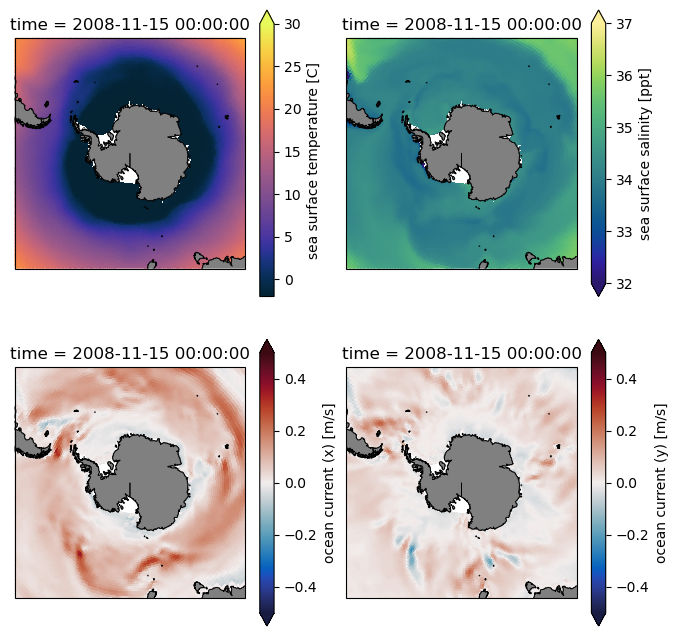

In [86]:
# Ocean forcing variables
for i, iGroup in enumerate(dt.groups[1:]):
    fig, axes = basic_axis([2, (len(ocn_forcing_vars) + 1) // 2])
    if histfreq[i] == "h":
        time_abbr = pd.Timestamp(str(dt[iGroup].isel(time=time_idx-1).copy()['time'].item()))
    elif histfreq[i] == "d":
        time_abbr = pd.Timestamp(dt[iGroup].isel(time=time_idx-1).copy()['time'].item())
    ds_plot = dt[iGroup].isel(time=time_idx-1).copy()
    for i, var in enumerate(ocn_forcing_vars):
        try:
            settings = get_plot_settings(var)
            settings
            ds_plot[var].plot(ax=axes.flat[i], x="TLON", y="TLAT", 
                              cmap=settings.get("cmap"),
                              vmin=settings.get("vmin"),
                              vmax=settings.get("vmax"),
                              transform=ccrs.PlateCarree()) 
        except KeyError:
            print(f"Variable '{var}' not found in dataset. Skipping.")
        except Exception as e:
            print(f"Error plotting variable '{var}': {e}. Skipping.")
    
    if len(ocn_forcing_vars) % 2 == 1:
        axes.flat[i+1].axis('off')
        axes.flat[i+1].remove()
    
    plt.savefig(fig_path + f"/ocn_forcing_{iGroup[1:]}_{time_abbr}.png", dpi=300, bbox_inches="tight") 

KeyError: 'Could not find node at wave_sig_ht'

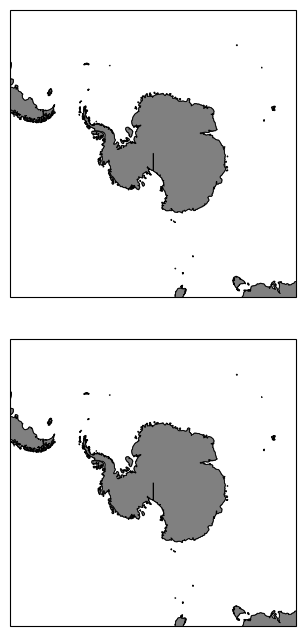

In [87]:
# Wave forcing variables
for i, iGroup in enumerate(dt.groups[1:]):
    fig, axes = basic_axis([2, (len(wave_forcing_vars) + 1) // 2])
    ds_plot = dt[iGroup].isel(time=time_idx-1).copy()
    for i, var in enumerate(wave_forcing_vars):
        try:
            settings = get_plot_settings(var)
            settings
            ds_plot[var].plot(ax=axes.flat[i], x="TLON", y="TLAT", 
                              cmap=settings.get("cmap"),
                              vmin=settings.get("vmin"),
                              vmax=settings.get("vmax"),
                              transform=ccrs.PlateCarree()) 
        except KeyError:
            print(f"Variable '{var}' not found in dataset. Skipping.")
        except Exception as e:
            print(f"Error plotting variable '{var}': {e}. Skipping.")
    
    if len(wave_forcing_vars) % 2 == 1:
        axes.flat[i+1].axis('off')
        axes.flat[i+1].remove() 
        
    plt.savefig(fig_path + f"/wave_forcing_{iGroup[1:]}_{time_abbr}.png", dpi=300, bbox_inches="tight") 

In [ ]:
# dt[dt.groups[2]]

### Compare two runs

KeyError: 'Could not find node at fsdrad'

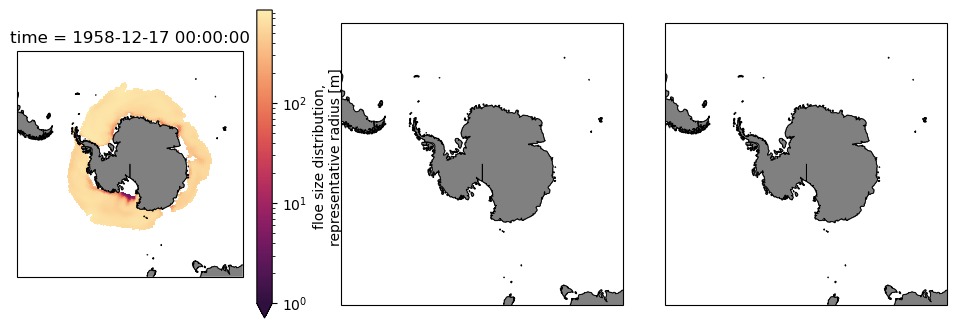

In [17]:
time_idx = 0

fig, axes = basic_axis([1,3])

ds_plot1 = dt[dt.groups[1]].isel(time=time_idx-1).copy()
ds_plot1["fsdrad"].where(ds_plot1["aice"]>0.15).plot(ax=axes[0], x="TLON", y="TLAT", cmap=cmo.matter_r, 
                                        norm=mcolors.LogNorm(vmin=1, vmax=850), transform=ccrs.PlateCarree()) 

ds_plot2 = dt[dt.groups[2]].isel(time=time_idx-1).copy()
ds_plot2["fsdrad"].where(ds_plot2["aice"]>0.15).plot(ax=axes[1], x="TLON", y="TLAT", cmap=cmo.matter_r, 
                                        norm=mcolors.LogNorm(vmin=1, vmax=850), transform=ccrs.PlateCarree()) 

difference = (ds_plot2["fsdrad"].where(ds_plot2["aice"]>0.15) - ds_plot1["fsdrad"].where(ds_plot1["aice"]>0.15))
difference.plot(ax=axes[2], x="TLON", y="TLAT", cmap=cmo.balance,
                vmin=-100, vmax=100 , transform=ccrs.PlateCarree()) 

## Make a quick movie 🎬

In [92]:
from io import BytesIO
# import xarray as xr
import matplotlib

matplotlib.use("Agg")
import imageio.v3 as iio


def fancier_plot(ds_sel, time, var, hemisphere="south"):
    if hemisphere == "south":
        projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
        lat_limits = [-90, -45]
    elif hemisphere == "north":
        projection = ccrs.NorthPolarStereo(true_scale_latitude=70)
        lat_limits = [45, 90]
    else:
        raise ValueError("Invalid hemisphere. Choose 'north' or 'south'.")


    fig, ax = plt.subplots(
                         subplot_kw={'projection': projection},
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

    # Add coastlines and land features
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                       edgecolor='black',
                                       facecolor='gray', linewidth=0.5)

    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    ax.set_extent([-180, 180, lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())

    plot_settings = {
        "aice": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},  # Ice concentration (0 to 1)
        "fsdrad": {"cmap": cmo.thermal, "vmin": 0, "vmax": 850},  # Floe size distribution radius (m)
        "hi": {"cmap": cmo.deep, "vmin": 0, "vmax": 5},  # Sea ice thickness (m)
        "hs": {"cmap": cmo.amp, "vmin": 0, "vmax": 0.5},  # Snow depth on sea ice (m)
        "hfs": {"cmap": cmo.amp, "vmin": 0, "vmax": 1},  # Snow thickness on refrozen leads (m)
        "tice": {"cmap": cmo.balance, "vmin": -30, "vmax": 0},  # Ice temperature (°C)
        "uvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},  # Ice velocity (zonal, m/s)
        "vvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},  # Ice velocity (meridional, m/s)
        "strength": {"cmap": cmo.matter, "vmin": 0, "vmax": 50e3},  # Ice strength (N/m)
        "divu": {"cmap": cmo.curl, "vmin": -1e-5, "vmax": 1e-5},  # Divergence (1/s)
        "shear": {"cmap": cmo.curl, "vmin": 0, "vmax": 1e-5},  # Shear strain rate (1/s)
        "uocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},  # Ocean current (zonal, m/s)
        "vocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},  # Ocean current (meridional, m/s)
        "wave_sig_ht": {"cmap": cmo.tempo, "vmin": 0, "vmax": 10},  # Significant wave height (m)
        "sst": {"cmap": cmo.thermal, "vmin": -2, "vmax": 30},
    }

    # Get the settings for the selected variable, defaulting to None if not found
    settings = plot_settings.get(var, {})

    # Apply the settings in the plot call
    ds_sel[var].plot(
        ax=ax,
        x="TLON",
        y="TLAT",
        cmap=settings.get("cmap"),
        vmin=settings.get("vmin"),
        vmax=settings.get("vmax"),
        transform=ccrs.PlateCarree(),
    )
    with BytesIO() as buf:
        fig.savefig(buf, format="png")
        plt.close(fig)
        image = iio.imread(buf.getvalue())
    return image



In [27]:
client = Client(threads_per_worker=1, memory_limit=0)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38975,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36885,Total threads: 1
Dashboard: /proxy/38197/status,Memory: 0 B
Nanny: tcp://127.0.0.1:38773,


In [93]:
%%time
import calendar
month = 2

model_name = 'cice6'
var = "sst"
hemisphere = "south"

for i, iGroup in enumerate(dt.groups[2:3]): # Remove index end?
    ds = dt[iGroup].copy()
    expt_name = iGroup[1:]
    ice_mask = (ds.aice > 0.15).compute()
    southern_ocean_mask = (ds.TLAT < -50).compute()
    combined_mask = ((ds.aice > 0.15) & (ds.TLAT < -50)).compute() # Mask not working
    ds_tmp = ds.where(southern_ocean_mask, drop=True).copy()
    ds_tmp = ds.chunk({"time": 1, "ni": -1, "nj": -1})

    futures = [
        client.submit(fancier_plot, ds_tmp.sel(time=time), time, var, hemisphere) for time in ds_tmp["time"].values
    ]

    with iio.imopen(os.path.join(fig_path,f"{var}_{model_name}_{expt_name}_{hemisphere}.gif"), "w", extension=".gif") as f:
        for future in futures:
            image = future.result()
            f.write(image)



CPU times: user 6.94 s, sys: 495 ms, total: 7.44 s
Wall time: 17.9 s


In [31]:

ds_tmp
# ds_tmp['fsdrad'].where(ice_mask, drop=True).isel(time=0).plot()

DataTree('test', parent=None)
    Dimensions:      (time: 31, nj: 116, ni: 100)
    Coordinates:
      * time         (time) datetime64[ns] 248B 2005-01-02 2005-01-03 ... 2005-02-01
        TLON         (nj, ni) float32 46kB dask.array<chunksize=(116, 100), meta=np.ndarray>
        TLAT         (nj, ni) float32 46kB dask.array<chunksize=(116, 100), meta=np.ndarray>
    Dimensions without coordinates: nj, ni
    Data variables:
        tarea        (time, nj, ni) float32 1MB dask.array<chunksize=(1, 116, 100), meta=np.ndarray>
        hi           (time, nj, ni) float32 1MB dask.array<chunksize=(1, 116, 100), meta=np.ndarray>
        aice         (time, nj, ni) float32 1MB dask.array<chunksize=(1, 116, 100), meta=np.ndarray>
        wave_sig_ht  (time, nj, ni) float32 1MB dask.array<chunksize=(1, 116, 100), meta=np.ndarray>
        fsdrad       (time, nj, ni) float32 1MB dask.array<chunksize=(1, 116, 100), meta=np.ndarray>
    Attributes:
        title:               sea ice model output for CICE
        contents:            Diagnostic and Prognostic Variables
        source:              Los Alamos Sea Ice Model, CICE_6.6.0
        comment:             This year has 365 days
        comment2:            File written on model date 20050102
        comment3:            seconds elapsed into model date:      0
        time_period_freq:    day_1
        time_axis_position:  end
        conventions:         CF-1.0
        history:             This dataset was created on 2025-05-29 at 15:23:38.4
        io_flavor:           io_netcdf

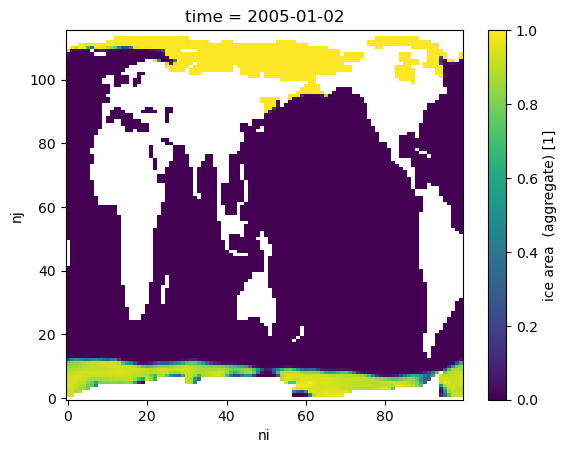

In [30]:
%matplotlib inline
ds_tmp['aice'].isel(time=0).plot()
plt.show()

In [10]:
# @map_over_subtree
# def sea_ice_area_model(ds, hemisphere="south"):
#     # print(ds.yt_ocean)
#     # sic = ds.aice_m.cf.sel(Y=slice(-90, 0))
    
#     if hemisphere == "south":
#         sic = ds.aice.sel(nj=slice(0,ds.nj.size//2))
#         variable_name = "si_area_south"
#     else:
#         sic = ds.aice.isel(nj=slice(ds.nj.size//2,ds.nj.size))
#         variable_name = "si_area_north"

#     print(type(sic))
    
#     # if isinstance(sic, DataTree):
#     #     print("sic is a DataTree object")
#     # else:
#     #     print("sic is NOT a DataTree object")
        
#     area_km2 = ds.tarea / 1e6
#     return sea_ice_area_model(sic, area_km2).to_dataset(name=variable_name).load()

In [166]:
def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

def sea_ice_area_model(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).sum(["ni", "nj"])

def sea_ice_extent(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

def sea_ice_extent_model(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).sum(["ni", "nj"])

In [59]:
@map_over_subtree
def calculate_SIA_SIE_model(ds):
    # Compute for Southern Hemisphere
    sic_south = ds.aice.where(ds.TLAT < 0)
    area_south_km2 = ds.tarea.where(ds.TLAT < 0) / 1e6
    si_area_south = sea_ice_area_model(sic_south, area_south_km2).to_dataset(name="si_area_south")
    si_extent_south = sea_ice_extent_model(sic_south, area_south_km2).to_dataset(name="si_extent_south")

    # Compute for Northern Hemisphere
    sic_north = ds.aice.where(ds.TLAT > 0)
    area_north_km2 = ds.tarea.where(ds.TLAT > 0) / 1e6
    si_area_north = sea_ice_area_model(sic_north, area_north_km2).to_dataset(name="si_area_north")
    si_extent_north = sea_ice_extent_model(sic_north, area_north_km2).to_dataset(name="si_extent_north")

    # Merge both hemispheres into a single dataset
    return xr.merge([si_area_south, si_extent_south, si_area_north, si_extent_north]).load()

In [60]:
model_SIA_SIE_dt = calculate_SIA_SIE_model(dt)
model_SIA_SIE_dt

DataTree('None', parent=None)
├── DataTree('baseline-1deg')
│       Dimensions:          (time: 12)
│       Coordinates:
│         * time             (time) object 96B 1958-01-16 00:00:00 ... 1958-12-16 00:...
│       Data variables:
│           si_area_south    (time) float32 48B 1.57e+06 1.167e+06 ... 1.058e+07
│           si_extent_south  (time) float32 48B 2.391e+06 2.047e+06 ... 1.602e+07
│           si_area_north    (time) float32 48B 1.566e+07 1.888e+07 ... 1.528e+07
│           si_extent_north  (time) float32 48B 1.82e+07 1.978e+07 ... 1.663e+07
├── DataTree('nofsd-1deg')
│       Dimensions:          (time: 24)
│       Coordinates:
│         * time             (time) object 192B 1958-01-16 00:00:00 ... 1959-12-16 00...
│       Data variables:
│           si_area_south    (time) float32 96B 1.742e+06 1.357e+06 ... 1.103e+07
│           si_extent_south  (time) float32 96B 2.608e+06 2.288e+06 ... 1.593e+07
│           si_area_north    (time) float32 96B 1.565e+07 1.889e+07 ... 1.484e+07
│           si_extent_north  (time) float32 96B 1.82e+07 1.978e+07 ... 1.647e+07
└── DataTree('wave-profile-1deg')
        Dimensions:          (time: 24)
        Coordinates:
          * time             (time) object 192B 1958-01-16 00:00:00 ... 1959-12-16 00...
        Data variables:
            si_area_south    (time) float32 96B 1.457e+07 1.007e+07 ... 7.566e+06
            si_extent_south  (time) float32 96B 2.027e+07 1.792e+07 ... 1.275e+07
            si_area_north    (time) float32 96B 1.676e+07 1.885e+07 ... 1.487e+07
            si_extent_north  (time) float32 96B 1.857e+07 1.973e+07 ... 1.649e+07

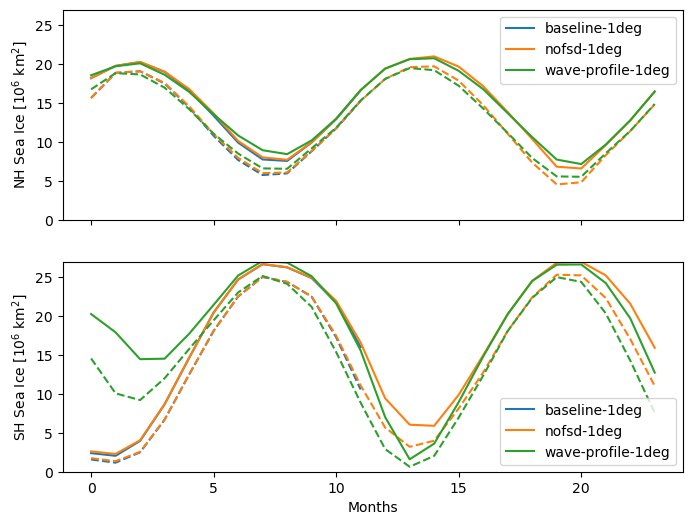

In [61]:
%matplotlib inline

import seaborn as sns
cmap = sns.color_palette(n_colors=6)


fig, axes = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

for i, iGroup in enumerate(model_SIA_SIE_dt.groups[1:]):
    # Top panel: Northern Hemisphere
    axes[0].plot(model_SIA_SIE_dt[iGroup]['si_extent_north'] * 1e-6, label=iGroup[1:], color=cmap[i])
    axes[0].plot(model_SIA_SIE_dt[iGroup]['si_area_north'] * 1e-6, linestyle='--', label='_nolegend_', color=cmap[i])
    axes[0].set_ylabel("NH Sea Ice [$10^6$ km$^2$]")


    # Bottom panel: Southern Hemisphere
    axes[1].plot(model_SIA_SIE_dt[iGroup]['si_extent_south'] * 1e-6, label=iGroup[1:], color=cmap[i])
    axes[1].plot(model_SIA_SIE_dt[iGroup]['si_area_south'] * 1e-6, linestyle='--', color=cmap[i], label='_nolegend_')
    axes[1].set_ylabel("SH Sea Ice [$10^6$ km$^2$]")
    axes[1].set_xlabel("Months")


for ax in axes:
    ax.set_ylim([0,27])
    ax.legend()

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/sie_{expt}.png", dpi=300, bbox_inches="tight") 
plt.show()

## Evolution of SIA-weighted variables

In [14]:
def sea_ice_area_weighted_average_model(data, sic, area, range=[0.15, 1]):
    mask = (sic >= range[0]) & (sic <= range[1])
    normalised_area = area.where(mask) / area.where(mask).sum(dim=["ni", "nj"])

    # Ensure normalised_area is properly computed before printing
    if False:
        max_value = normalised_area.max().compute()  # Use .compute() if using Dask
        total_sum = normalised_area.sum().compute()  # Should be ~1.0
    
        print(max_value.values)
        print(total_sum.values)

    return (data * normalised_area).where(mask).sum(dim=["ni", "nj"])

In [15]:
@map_over_subtree
def calculate_sea_ice_average_model(ds, var):
    # Compute for Southern Hemisphere
    data_south = ds[var].where(ds.TLAT < 0)
    aice_south = ds.aice.where(ds.TLAT < 0)
    area_south_km2 = ds.tarea.where(ds.TLAT < 0)
    si_ave_south = sea_ice_area_weighted_average_model(data_south, aice_south, area_south_km2).to_dataset(name="si_ave_south")
    

    # Compute for Northern Hemisphere
    data_north = ds[var].where(ds.TLAT > 0)
    aice_north = ds.aice.where(ds.TLAT > 0)
    area_north_km2 = ds.tarea.where(ds.TLAT > 0)
    si_ave_north = sea_ice_area_weighted_average_model(data_north, aice_north, area_north_km2).to_dataset(name="si_ave_north")

    # Merge both hemispheres into a single dataset
    return xr.merge([si_ave_south, si_ave_north]).load()

In [16]:
var = "hi"
model_average_dt = calculate_sea_ice_average_model(dt, var)
model_average_dt

DataTree('None', parent=None)
├── DataTree('baseline-1deg')
│       Dimensions:       (time: 12)
│       Coordinates:
│         * time          (time) object 96B 1958-01-16 00:00:00 ... 1958-12-16 00:00:00
│       Data variables:
│           si_ave_south  (time) float32 48B 1.656 1.324 0.6593 ... 1.15 1.193 1.093
│           si_ave_north  (time) float32 48B 1.443 1.623 1.78 ... 1.669 1.538 1.478
├── DataTree('wave-constant-1deg')
│       Dimensions:       (time: 24)
│       Coordinates:
│         * time          (time) object 192B 1958-01-16 00:00:00 ... 1959-12-16 00:00:00
│       Data variables:
│           si_ave_south  (time) float32 96B 1.657 1.333 0.6575 ... 1.148 1.217 1.157
│           si_ave_north  (time) float32 96B 1.442 1.623 1.778 ... 1.292 1.256 1.263
├── DataTree('wave-profile-1deg')
│       Dimensions:       (time: 72)
│       Coordinates:
│         * time          (time) object 576B 1958-01-16 00:00:00 ... 1963-12-16 00:00:00
│       Data variables:
│           si_ave_south  (time) float32 288B 1.655 1.314 0.6466 ... 1.392 1.367 1.157
│           si_ave_north  (time) float32 288B 1.458 1.673 1.851 ... 2.304 2.061 1.929
├── DataTree('wave-random-1deg')
│       Dimensions:       (time: 7)
│       Coordinates:
│         * time          (time) object 56B 1958-01-16 00:00:00 ... 1958-07-16 00:00:00
│       Data variables:
│           si_ave_south  (time) float32 28B 1.657 1.333 0.6575 ... 0.5534 0.629 0.7317
│           si_ave_north  (time) float32 28B 1.442 1.623 1.778 1.994 2.202 2.351 2.265
└── DataTree('nofsd-1deg')
        Dimensions:       (time: 120)
        Coordinates:
          * time          (time) object 960B 1958-01-16 00:00:00 ... 1967-12-16 00:00:00
        Data variables:
            si_ave_south  (time) float32 480B 1.603 1.29 0.6863 ... 1.112 1.131 0.958
            si_ave_north  (time) float32 480B 1.441 1.623 1.778 ... 2.213 1.92 1.807

/baseline-1deg
/wave-constant-1deg
/wave-profile-1deg
/wave-random-1deg
/nofsd-1deg


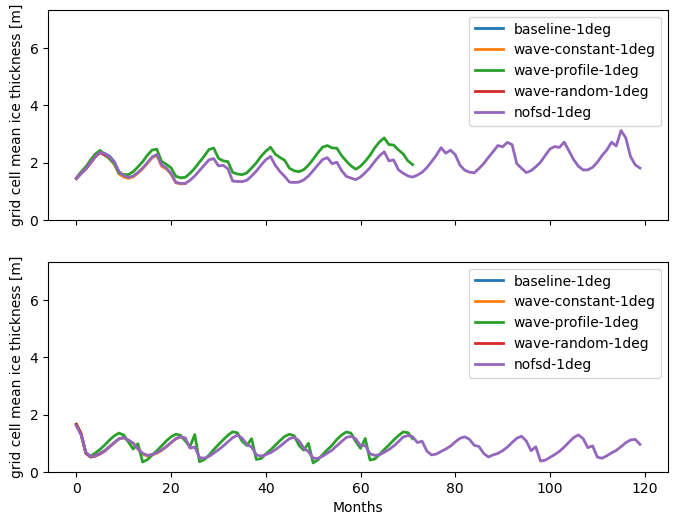

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
cmap = sns.color_palette(n_colors=6)

# Initialize lists to store previous lines for comparison
previous_lines_north = []
previous_lines_south = []

fig, axes = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

for i, iGroup in enumerate(model_average_dt.groups[1:]):
    print(iGroup)
    # Get data
    si_ave_north = model_average_dt[iGroup]['si_ave_north']
    si_ave_south = model_average_dt[iGroup]['si_ave_south']
    
    # Check overlap with previous lines
    # linestyle_north = "--" if any(np.allclose(si_ave_north, prev, atol=0.01) for prev in previous_lines_north) else "-"
    # linestyle_south = "--" if any(np.allclose(si_ave_south, prev, atol=0.01) for prev in previous_lines_south) else "-"

    # Top panel: Northern Hemisphere
    axes[0].plot(si_ave_north, label=iGroup[1:], color=cmap[i], linestyle='-', linewidth=2)
    previous_lines_north.append(si_ave_north)  # Store for future comparison

    # Bottom panel: Southern Hemisphere
    axes[1].plot(si_ave_south, label=iGroup[1:], color=cmap[i], linestyle='-', linewidth=2)
    previous_lines_south.append(si_ave_south)  # Store for future comparison

    axes[1].set_xlabel("Months")

    long_name = dt[iGroup][var].long_name
    units = dt[iGroup][var].units
    wrapped_name = "\n".join(textwrap.wrap(long_name, width=30))  
    axes[0].set_ylabel(f"{wrapped_name} [{units}]")
    axes[1].set_ylabel(f"{wrapped_name} [{units}]")

for ax in axes:
    ax.set_ylim([0, dt[iGroup][var].max().values])
    ax.legend()

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/ts_sea_ice_average_{expt}_{var}.png", dpi=300, bbox_inches="tight") 
plt.show()

In [19]:
def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

def sea_ice_area_model(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).sum(["ni", "nj"])

def sea_ice_extent(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

def sea_ice_extent_model(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).sum(["ni", "nj"])

In [20]:
@map_over_subtree
def polar_sea_ice_area_model(ds, hemisphere="south"):
    # print(ds.yt_ocean)
    # sic = ds.aice.cf.sel(Y=slice(-90, 0))
    
    if hemisphere == "south":
        sic = ds.aice.isel(nj=slice(0, ds.nj.size//2))
        # sic = ds.aice.cf.sel(Y=slice(-90, 0))
        variable_name = "si_area_south"
        area_km2 = ds.tarea.isel(nj=slice(0, ds.nj.size//2)) / 1e6
    else:
        sic = ds.aice.isel(nj=slice(ds.nj.size//2,ds. nj.size))
        variable_name = "si_area_north"
        area_km2 = ds.tarea.isel(nj=slice(ds.nj.size//2,ds. nj.size)) / 1e6

        
    
    return sea_ice_area_model(sic, area_km2).to_dataset(name=variable_name).load()

In [21]:
@map_over_subtree
def polar_sea_ice_extent_model(ds, hemisphere="south"):
    # sic = ds.aice.cf.sel(Y=slice(-90, 0))
    # sic = ds.aice.cf.sel(yt_ocean=slice(0, 150))
    if hemisphere == "south":
        sic = ds.aice.where(ds.TLAT<0)
        variable_name = "si_extent_south"
    else:
        sic = ds.aice.where(ds.TLAT>0)
        variable_name = "si_extent_north"
        
    area_km2 = ds.tarea / 1e6

  
    return sea_ice_extent_model(sic, area_km2).to_dataset(name=variable_name).load()

In [22]:
@map_over_subtree
def polar_sea_ice_volume_model(ds, hemisphere="south"):
    if hemisphere == "south":
        sic = ds.aice.where(ds.TLAT<0) * ds.hi.where(ds.TLAT<0)
        variable_name = "si_volume_south"
    else:
        sic = ds.aice.where(ds.TLAT>0) * ds.hi.where(ds.TLAT>0)
        variable_name = "si_volume_north"
        
    area_km2 = ds.tarea / 1e6
  
    return sea_ice_area_model(sic, area_km2).to_dataset(name=variable_name).load()

In [23]:
model_area_sh_dt = polar_sea_ice_area_model(dt)
model_area_nh_dt = polar_sea_ice_area_model(dt, hemisphere="north")

model_extent_sh_dt = polar_sea_ice_extent_model(dt)
model_extent_nh_dt = polar_sea_ice_extent_model(dt, hemisphere="north")

model_volume_sh_dt = polar_sea_ice_volume_model(dt)
model_volume_nh_dt = polar_sea_ice_volume_model(dt, hemisphere="north")

In [24]:
dt

DataTree('None', parent=None)
├── DataTree('baseline-1deg')
│       Dimensions:      (time: 12, nj: 300, ni: 360)
│       Coordinates:
│         * time         (time) object 96B 1958-01-16 00:00:00 ... 1958-12-16 00:00:00
│           TLON         (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
│           TLAT         (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
│       Dimensions without coordinates: nj, ni
│       Data variables: (12/17)
│           tarea        (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           hi           (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           aice         (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           icespd       (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           uatm         (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           vatm         (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           ...           ...
│           uocn         (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           vocn         (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           Tair         (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           Qref         (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           iage         (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           wave_sig_ht  (time, nj, ni) float32 5MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│       Attributes:
│           title:               sea ice model output for CICE
│           contents:            Diagnostic and Prognostic Variables
│           source:              Los Alamos Sea Ice Model, CICE_6.6.0
│           comment:             All years have exactly 365 days
│           comment2:            File written on model date 19580201
│           comment3:            seconds elapsed into model date:      0
│           time_period_freq:    month_1
│           time_axis_position:  end
│           conventions:         CF-1.0
│           history:             This dataset was created on 2025-06-05 at 13:20:29.2
│           io_flavor:           io_netcdf
├── DataTree('wave-constant-1deg')
│       Dimensions:      (time: 24, nj: 300, ni: 360)
│       Coordinates:
│         * time         (time) object 192B 1958-01-16 00:00:00 ... 1959-12-16 00:00:00
│           TLON         (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
│           TLAT         (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
│       Dimensions without coordinates: nj, ni
│       Data variables: (12/15)
│           tarea        (time, nj, ni) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           hi           (time, nj, ni) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           aice         (time, nj, ni) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           icespd       (time, nj, ni) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           uatm         (time, nj, ni) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           vatm         (time, nj, ni) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           ...           ...
│           sss          (time, nj, ni) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           uocn         (time, nj, ni) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           vocn         (time, nj, ni) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           Tair         (time, nj, ni) float32 10MB dask.array<chunksize=(1, 30

### Annual cycle

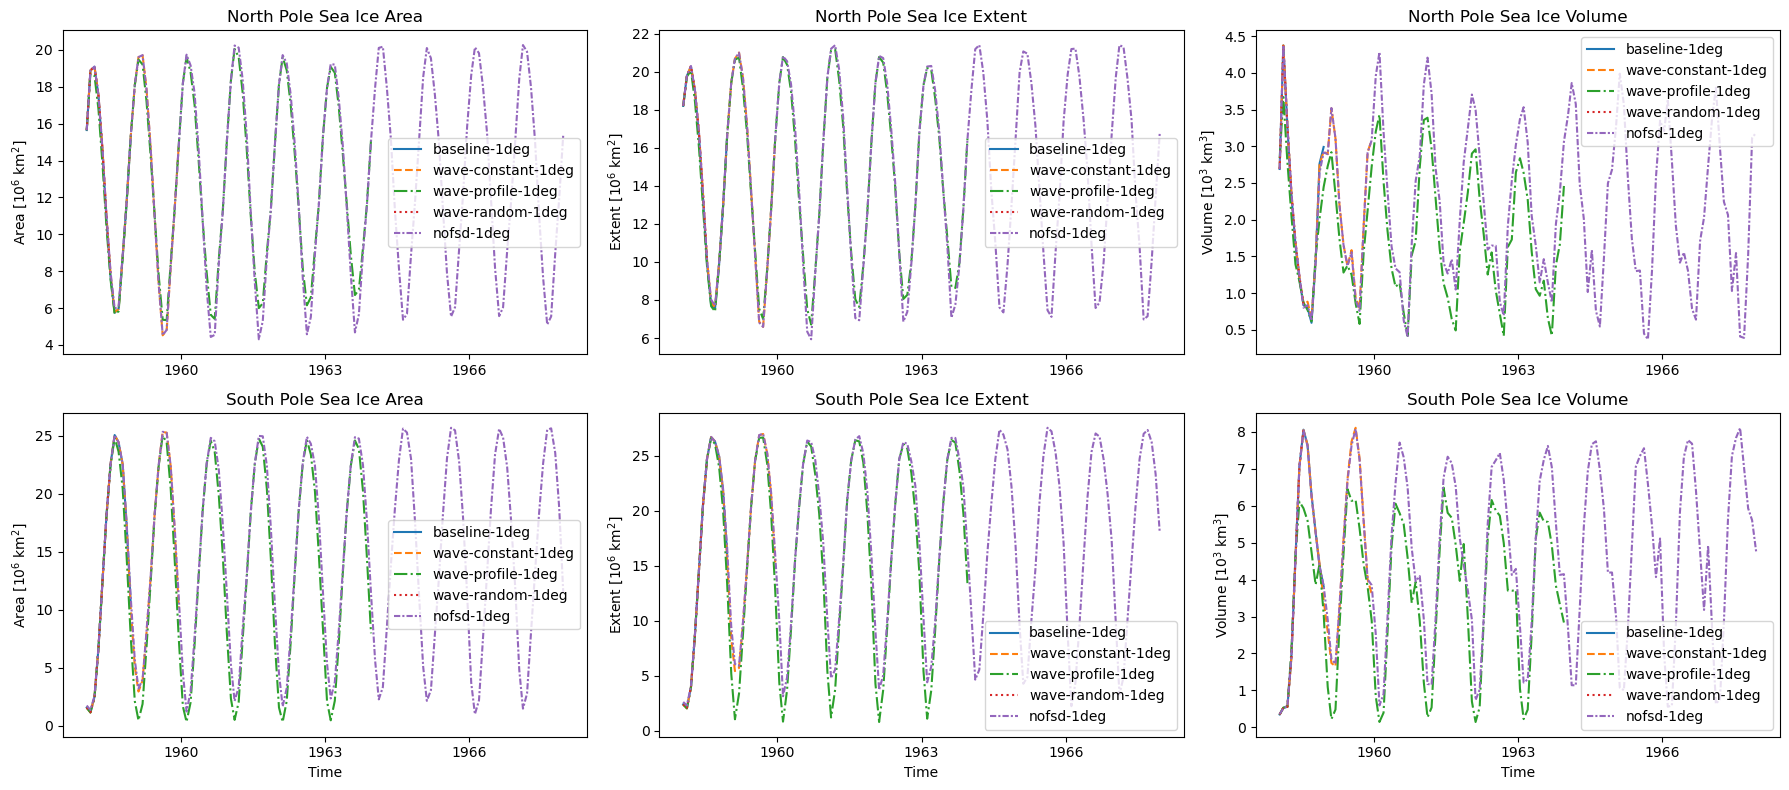

In [37]:
import itertools

# Define unique color-linestyle combinations
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # last is a dash-dot-dot custom pattern
styles = list(zip(colors, linestyles))

fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# --- North Pole ---

# Area
for i, iGroup in enumerate(model_average_dt.groups[1:]):
    (1e-6 * model_area_nh_dt[iGroup]['si_area_north']).plot(ax=axs[0, 0], label=iGroup[1:], 
                                                            color=styles[i][0], linestyle=styles[i][1])
axs[0, 0].set_title("North Pole Sea Ice Area")
axs[0, 0].set_ylabel("Area [10$^6$ km$^2$]")
axs[0, 0].legend()

# Extent
for i, iGroup in enumerate(model_average_dt.groups[1:]):
    (1e-6 * model_extent_nh_dt[iGroup]['si_extent_north']).plot(ax=axs[0, 1], label=iGroup[1:], 
                                                                 color=styles[i][0], linestyle=styles[i][1])
axs[0, 1].set_title("North Pole Sea Ice Extent")
axs[0, 1].set_ylabel("Extent [10$^6$ km$^2$]")
axs[0, 1].legend()

# Volume
for i, iGroup in enumerate(model_average_dt.groups[1:]):
    (1e-6 * model_volume_nh_dt[iGroup]['si_volume_north']).plot(ax=axs[0, 2], label=iGroup[1:], 
                                                                 color=styles[i][0], linestyle=styles[i][1])
axs[0, 2].set_title("North Pole Sea Ice Volume")
axs[0, 2].set_ylabel("Volume [10$^3$ km$^3$]")
axs[0, 2].legend()

# --- South Pole ---

# Area
for i, iGroup in enumerate(model_average_dt.groups[1:]):
    (1e-6 * model_area_sh_dt[iGroup]['si_area_south']).plot(ax=axs[1, 0], label=iGroup[1:], 
                                                             color=styles[i][0], linestyle=styles[i][1])
axs[1, 0].set_title("South Pole Sea Ice Area")
axs[1, 0].set_ylabel("Area [10$^6$ km$^2$]")
axs[1, 0].legend()

# Extent
for i, iGroup in enumerate(model_average_dt.groups[1:]):
    (1e-6 * model_extent_sh_dt[iGroup]['si_extent_south']).plot(ax=axs[1, 1], label=iGroup[1:], 
                                                                 color=styles[i][0], linestyle=styles[i][1])
axs[1, 1].set_title("South Pole Sea Ice Extent")
axs[1, 1].set_ylabel("Extent [10$^6$ km$^2$]")
axs[1, 1].legend()

# Volume
for i, iGroup in enumerate(model_average_dt.groups[1:]):
    (1e-6 * model_volume_sh_dt[iGroup]['si_volume_south']).plot(ax=axs[1, 2], label=iGroup[1:], 
                                                                 color=styles[i][0], linestyle=styles[i][1])
axs[1, 2].set_title("South Pole Sea Ice Volume")
axs[1, 2].set_ylabel("Volume [10$^3$ km$^3$]")
axs[1, 2].legend()

# Set common xlabel for bottom row
for ax in axs[0, :]:
    ax.set_xlabel("")
for ax in axs[1, :]:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/annual_SIA_SIE_SIV_cycle_{model_extent_sh_dt.groups[1][1:]}_{model_extent_sh_dt.groups[2][1:]}.png", dpi=900, bbox_inches="tight")
plt.show()

In [ ]:
# (1e-6*model_extent_sh_dt['baseline-1deg']['si_area_south']).plot(label='FSD (no waves)')
# (1e-6*model_extent_sh_dt['nofsd-1deg']['si_area_south']).plot(linestyle='--', label='No FSD')
# plt.ylim(bottom=0)
# plt.legend()
# plt.ylabel("Sea ice extent [10$^6$ km$^2$]")
# plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/annual_SIE_cycle_{model_extent_sh_dt.groups[1][1:]}_{model_extent_sh_dt.groups[2][1:]}.png", dpi=300, bbox_inches="tight") 
# plt.show()

In [21]:
model_extent_nh_dt

DataTree('None', parent=None)
├── DataTree('baseline-1deg')
│       Dimensions:          (time: 12)
│       Coordinates:
│         * time             (time) object 96B 1958-01-16 00:00:00 ... 1958-12-16 00:...
│       Data variables:
│           si_extent_north  (time) float32 48B 1.82e+07 1.978e+07 ... 1.663e+07
├── DataTree('nofsd-1deg')
│       Dimensions:          (time: 12)
│       Coordinates:
│         * time             (time) object 96B 1958-01-16 00:00:00 ... 1958-12-16 00:...
│       Data variables:
│           si_extent_north  (time) float32 48B 1.82e+07 1.978e+07 ... 1.665e+07
└── DataTree('wave-profile-1deg')
        Dimensions:          (time: 12)
        Coordinates:
          * time             (time) object 96B 1958-01-16 00:00:00 ... 1958-12-16 00:...
        Data variables:
            si_extent_north  (time) float32 48B 1.857e+07 1.973e+07 ... 1.667e+07

In [44]:
model_min_max_nh_dt

DataTree('None', parent=None)
├── DataTree('baseline-1deg')
│       Dimensions:  (year: 1)
│       Coordinates:
│         * year     (year) int64 8B 1958
│       Data variables:
│           min      (year) float64 8B 5.747e+06
│           max      (year) float64 8B 1.909e+07
├── DataTree('wave-constant-1deg')
│       Dimensions:  (year: 2)
│       Coordinates:
│         * year     (year) int64 16B 1958 1959
│       Data variables:
│           min      (year) float64 16B 5.778e+06 4.523e+06
│           max      (year) float64 16B 1.91e+07 1.971e+07
├── DataTree('wave-profile-1deg')
│       Dimensions:  (year: 6)
│       Coordinates:
│         * year     (year) int64 48B 1958 1959 1960 1961 1962 1963
│       Data variables:
│           min      (year) float64 48B 5.69e+06 5.346e+06 ... 6.153e+06 6.707e+06
│           max      (year) float64 48B 1.873e+07 1.948e+07 ... 1.961e+07 1.908e+07
├── DataTree('wave-random-1deg')
│       Dimensions:  (year: 1)
│       Coordinates:
│         * year     (year) int64 8B 1958
│       Data variables:
│           min      (year) float64 8B 7.82e+06
│           max      (year) float64 8B 1.91e+07
└── DataTree('nofsd-1deg')
        Dimensions:  (year: 10)
        Coordinates:
          * year     (year) int64 80B 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967
        Data variables:
            min      (year) float64 80B 5.984e+06 4.536e+06 ... 5.564e+06 5.107e+06
            max      (year) float64 80B 1.91e+07 1.972e+07 ... 2.014e+07 2.027e+07

### Annual min and max extent analysis

In [40]:
@map_over_subtree
def min_and_max(ds, hemisphere="south", ice_var="area"):
    def min_and_max_year(da):
        result = xr.Dataset()
        result["min"] = da.min()
        result["max"] = da.max()
        return result
        
    annual_min_max_ds = ds[f"si_{ice_var}_{hemisphere}"].groupby("time.year").apply(min_and_max_year)
    return annual_min_max_ds

model_min_max_sh_dt = min_and_max(model_area_sh_dt)
model_min_max_extent_sh_dt = min_and_max(model_extent_sh_dt, ice_var="extent")

model_min_max_nh_dt = min_and_max(model_area_nh_dt, hemisphere="north")
model_min_max_extent_nh_dt = min_and_max(model_extent_nh_dt, hemisphere="north", ice_var="extent")

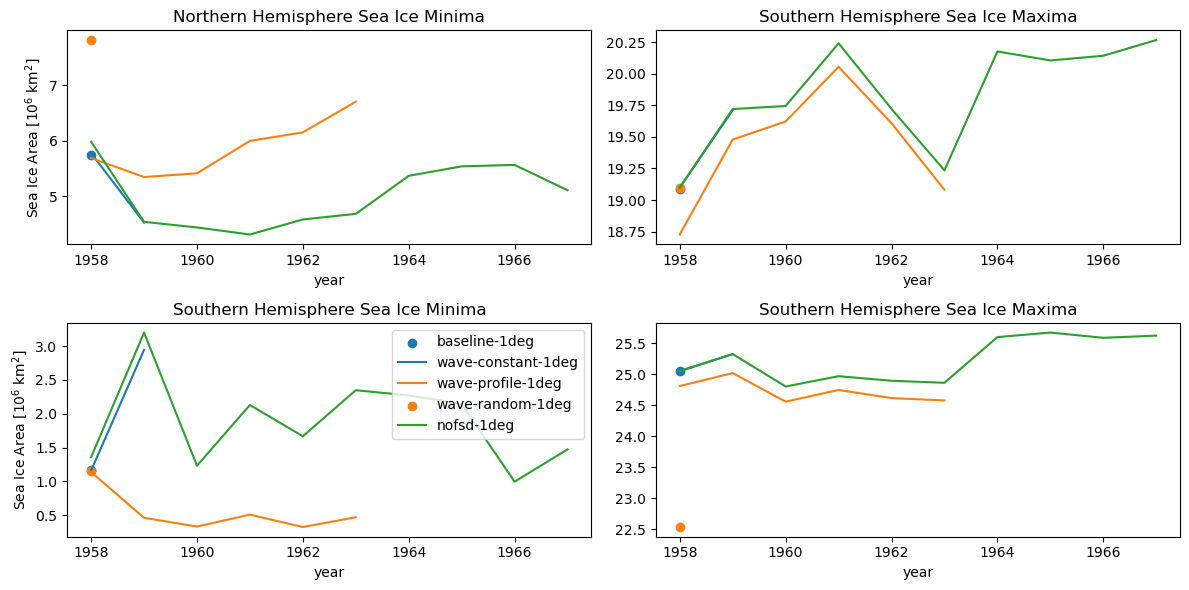

In [54]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharey=False)

# Southern Hemisphere subplot
ax = axes[1,0]
for iGroup in model_min_max_sh_dt.groups[1:]:
    ds = model_min_max_sh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    
    if len(ds["min"]) == 1:
        ax.scatter(ds["min"].coords["year"], 1e-6*ds["min"].values, label=iGroup[1:])
    else:
        (1e-6*ds["min"]).plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

# obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')

ax.set_title("Southern Hemisphere Sea Ice Minima")
ax.set_ylabel("Sea Ice Area [$10^6$ km$^2$]")
ax.legend()

# Northern Hemisphere subplot
ax = axes[0,0]
for iGroup in model_min_max_nh_dt.groups[1:]:
    ds = model_min_max_nh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    if len(ds["min"]) == 1:
        ax.scatter(ds["min"].coords["year"], 1e-6*ds["min"].values, label=iGroup[1:])
    else:
        (1e-6*ds["min"]).plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

# obs_area_dt["cdr_nh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')


ax.set_ylabel("Sea Ice Area [$10^6$ km$^2$]")
ax.set_title("Northern Hemisphere Sea Ice Minima")




# Southern Hemisphere subplot
ax = axes[1,1]
for iGroup in model_min_max_sh_dt.groups[1:]:
    ds = model_min_max_sh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    
    if len(ds["max"]) == 1:
        ax.scatter(ds["max"].coords["year"], 1e-6*ds["max"].values, label=iGroup[1:])
    else:
        (1e-6*ds["max"]).plot(ax=ax, label=iGroup[1:], linestyle=linestyle)
ax.set_title("Southern Hemisphere Sea Ice Maxima")
ax.set_ylabel("")

# Northern Hemisphere subplot
ax = axes[0,1]
for iGroup in model_min_max_nh_dt.groups[1:]:
    ds = model_min_max_nh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    if len(ds["min"]) == 1:
        ax.scatter(ds["max"].coords["year"], 1e-6*ds["max"].values, label=iGroup[1:])
    else:
        (1e-6*ds["max"]).plot(ax=ax, label=iGroup[1:], linestyle=linestyle)
ax.set_title("Southern Hemisphere Sea Ice Maxima")
ax.set_ylabel("")


plt.tight_layout()
# plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area_min_subplot.png", dpi=300, bbox_inches="tight")
plt.show()

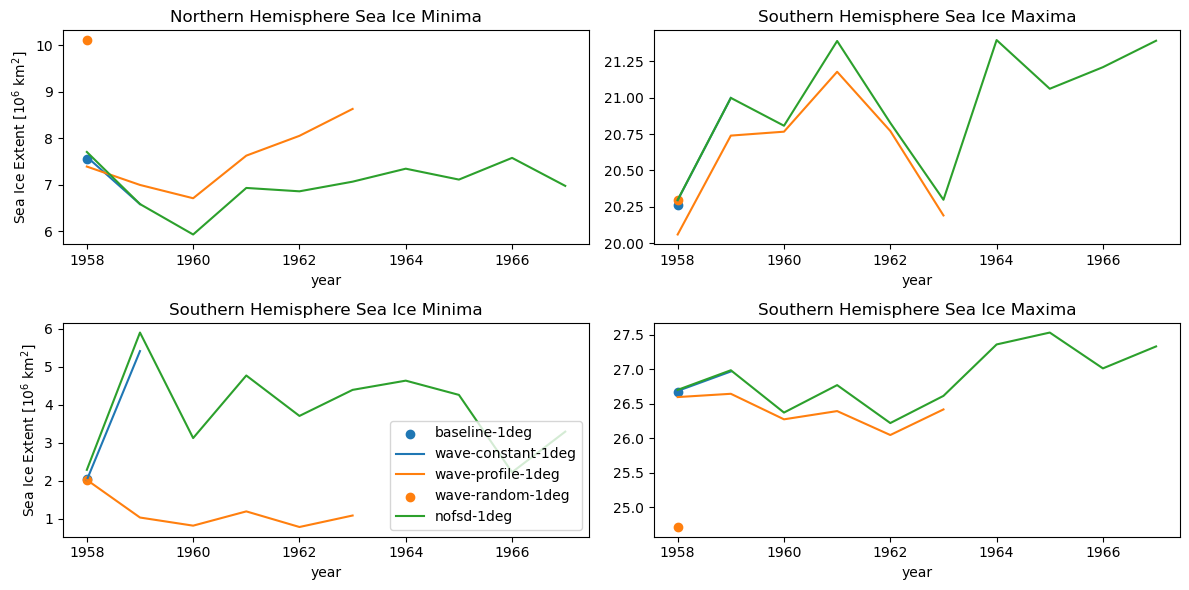

In [56]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharey=False)

# Southern Hemisphere subplot
ax = axes[1,0]
for iGroup in model_min_max_extent_sh_dt.groups[1:]:
    ds = model_min_max_extent_sh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    
    if len(ds["min"]) == 1:
        ax.scatter(ds["min"].coords["year"], 1e-6*ds["min"].values, label=iGroup[1:])
    else:
        (1e-6*ds["min"]).plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

# obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')

ax.set_title("Southern Hemisphere Sea Ice Minima")
ax.set_ylabel("Sea Ice Extent [$10^6$ km$^2$]")
ax.legend()

# Northern Hemisphere subplot
ax = axes[0,0]
for iGroup in model_min_max_extent_nh_dt.groups[1:]:
    ds = model_min_max_extent_nh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    if len(ds["min"]) == 1:
        ax.scatter(ds["min"].coords["year"], 1e-6*ds["min"].values, label=iGroup[1:])
    else:
        (1e-6*ds["min"]).plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

# obs_area_dt["cdr_nh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')


ax.set_ylabel("Sea Ice Extent [$10^6$ km$^2$]")
ax.set_title("Northern Hemisphere Sea Ice Minima")




# Southern Hemisphere subplot
ax = axes[1,1]
for iGroup in model_min_max_extent_sh_dt.groups[1:]:
    ds = model_min_max_extent_sh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    
    if len(ds["max"]) == 1:
        ax.scatter(ds["max"].coords["year"], 1e-6*ds["max"].values, label=iGroup[1:])
    else:
        (1e-6*ds["max"]).plot(ax=ax, label=iGroup[1:], linestyle=linestyle)
ax.set_title("Southern Hemisphere Sea Ice Maxima")
ax.set_ylabel("")

# Northern Hemisphere subplot
ax = axes[0,1]
for iGroup in model_min_max_extent_nh_dt.groups[1:]:
    ds = model_min_max_extent_nh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    if len(ds["min"]) == 1:
        ax.scatter(ds["max"].coords["year"], 1e-6*ds["max"].values, label=iGroup[1:])
    else:
        (1e-6*ds["max"]).plot(ax=ax, label=iGroup[1:], linestyle=linestyle)
ax.set_title("Southern Hemisphere Sea Ice Maxima")
ax.set_ylabel("")


plt.tight_layout()
# plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area_min_subplot.png", dpi=300, bbox_inches="tight")
plt.show()

# Runtime analysis

In [4]:

    # "wave-1deg": ["baseline-1deg", "wave-constant-1deg", "wave-profile-1deg", "wave-random-1deg", "nofsd-1deg"],
# }
# experiments = experiment_sets["wave-1deg"]
for Expt in experiments:
    dates = model_average_dt[Expt].time
    start_date = dates[0]
    end_date = dates[-1]
    date_difference = end_date - start_date
    days = date_difference.values.astype('timedelta64[D]') + 1
    
    expt_dir = os.path.join(expt_path, Expt)
    
    # Find all cice.runlog.* files in the experiment directory, sorted by modification time (newest first)
    log_files = sorted(glob.glob(os.path.join(expt_dir, "cice.runlog.*")), key=os.path.getmtime, reverse=True)

    if not log_files:
        print(f"{Expt}: No log files found")
        continue

    total_time = None

    # Try reading log files in order of newest to oldest
    for log_file in log_files:
        with open(log_file, "r") as file:
            log_text = file.read()

        match = re.search(r"Total\s+([\d.]+)\s+seconds", log_text)
        if match:
            total_time = float(match.group(1))
            print(f"{Expt}: Walltime: {np.round(total_time/60)} minutes [{np.round(total_time/60/days.astype('int'),3)} min per model day] ({log_file})")
            break  # Stop once a valid time is found
    
    if total_time is None:
        print(f"{Expt}: Total time not found in any log file")

IndentationError: expected an indented block after 'for' statement on line 4 (498675168.py, line 5)

In [95]:
dates

<xarray.DataArray 'time' (time: 11)>
array(['2005-02-01T00:00:00.000000000', '2005-03-01T00:00:00.000000000',
       '2005-04-01T00:00:00.000000000', '2005-05-01T00:00:00.000000000',
       '2005-06-01T00:00:00.000000000', '2005-07-01T00:00:00.000000000',
       '2005-08-01T00:00:00.000000000', '2005-09-01T00:00:00.000000000',
       '2005-10-01T00:00:00.000000000', '2005-11-01T00:00:00.000000000',
       '2005-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-02-01 2005-03-01 ... 2005-12-01
Attributes:
    long_name:  time
    bounds:     time_bounds